# Introduction

Another form of shrinkage that can be applied to the OLS problem is the Lasso. In this case, an $L_1$ penalty is added to the loss function, which has the effect of bringing model parameters to zero for a large enough value of the associated tuning parameter. In other words, this penalty performs automated feature selection since possibly some of the model parameters will be brought to zero.  

However, unlike the previous models, no closed-form solution exists due to the fact that the loss function is no longer continuously differentiable (non-smooth absolute component). Thus, discrete optimization techniques are needed to solve for the parameter estimates. Numerous algorithms, such as the LARS (Least Angle Regression) algorithm and the Forward Stepwise regression algorithm have been developed to solve the Lasso, however the Pathwise Coordinate Descent algorithm is leveraged here. 

# Algorithm

## Finding the Lasso Estimator

The Lasso loss function is similar to the OLS loss function but with the addition of an $L_1$ penalty:

$$ L(\mathbf{\beta}) =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2 + \lambda\|\mathbf{\beta}\|_1 \: \: \: \text{ with tuning parameter $\lambda \geq 0$} $$

The Lasso problem is also formalized as a least squares optimization problem: 

$$ \hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}}  L(\mathbf{\beta}) = \arg\min_{\mathbf{\beta}} \|\mathbf{y}-\mathbf{X}\mathbf{\beta} \|_{2}^{2} + \lambda\|\mathbf{\beta}\|_1 $$

In order to solve this problem, `pathwise coordinate descent` is implemented. The algorithm utilizes the notion of optimizing a single parameter at a time while holding all others fixed. 

Since the number of samples is much greater than the number of features in this case, covariance updates are used where cross-covariance terms are computed and stored for active variables. Warm starts, fitting a sequence of models ranging on a log scale from the maximum value of the tuning parameter down to a minimum value, are used to further speed up the convergence of the algorithm. 

An intercept term can be found similarly to the OLS case. 


# Class

In [1]:
import pandas as pd
import numpy as np

In [2]:
class LassoRegression:
    def __init__(self, learning_rate= 0.01, n_iters= 1000, lambda_l= 1):
        self.lr = learning_rate
        self.iterations = n_iters
        self.lambda_l = lambda_l
        self.theta = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.theta = np.random.random_sample(n_features)
        self.bias = np.random.random_sample()

        loss = []
        for _ in range(self.iterations):
            linear_model = X @ self.theta + self.bias
            d_theta = np.zeros(n_features)
            for j in range(n_features):
                if self.theta[j] > 0:
                    d_theta[j] = (1 / n_samples) * ( -(2 * (X[:, j] @ (y - linear_model))) + self.lambda_l)
                else:
                    d_theta[j] = (1 / n_samples) * ( -(2 * (X[:, j] @ (y - linear_model))) - self.lambda_l)
            d_bias = (1 / n_samples) * (- 2 * np.sum(y - linear_model))
            self.theta -= self.lr * d_theta
            self.bias -= self.lr * d_bias
            loss.append(self._calculate_cost(y, linear_model, self.lambda_l, self.theta))
        self.loss = loss
    def predict(self, X):
        return X @ self.theta + self.bias
    
    def cost(self):
        return self.loss

    def _calculate_cost(self, y, z, lambda_l, theta):
        n_samples = y.shape[0] 
        lasso_loss = (1/n_samples) * np.sum(np.square(y - z)) + (lambda_l * np.sum(np.abs(theta)))
        return np.sqrt(lasso_loss) 


# Example

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def my_plot(cost):
    iterations = [i for i in range(1, 1001)]
    fig, ax = plt.subplots()
    ax.plot(iterations, cost, color='red')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title('Cost vs Iterations')
    
def surface_plot(X, y, prediction, degree):
    fig = plt.figure(figsize=[30, 50])
    ax = fig.add_subplot(5, 2, degree, projection='3d')
    ax.scatter(X[:,0], X[:,1], y, zdir='z', s=20, c='#9467bd', depthshade=True)
    Y_plot = np.asarray(prediction)
    X = np.asarray(X)
    ax.plot_trisurf(X[:, 0], X[:, 1], Y_plot, cmap = 'viridis')
    ax.set_xlabel('$Age$', fontsize=10, rotation=150)
    ax.set_ylabel('$BMI$', fontsize=10, rotation=150)
    ax.set_zlabel('$Insurance$', fontsize=10, rotation=60)
    ax.set_title('Degree: ' + str(degree), fontsize=20)
    plt.show()

## Data

In [4]:
data = pd.read_csv('../data/insurance.txt')
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(4, include_bias= False)
X = data.iloc[:, :3]
X = poly.fit_transform(X)
X = (X - X.mean(axis= 0)) / X.std(axis= 0)
y = data.iloc[:, 3]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [5]:
lasso = LassoRegression(learning_rate= 0.01, n_iters= 1000, lambda_l= 500)
lasso.fit(X_train, y_train)
y_predicted_l = lasso.predict(X_train)
cost_lasso = lasso.cost()

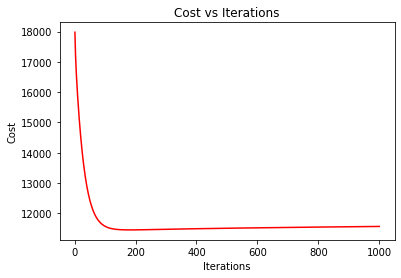

In [6]:
my_plot(cost_lasso)

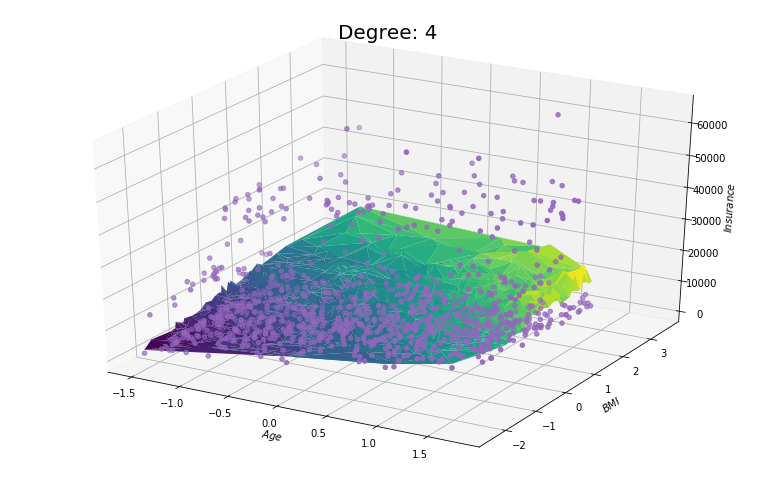

In [7]:
surface_plot(X_train, y_train, y_predicted_l, 4)